In [55]:
# !pip install text-hammer
# !pip install spacy -q
# !python -m spacy download en_core_web_sm -q
# !pip install xgboost

You should consider upgrading via the 'c:\users\egorm\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
flag = False
test_df = pd.read_csv('test_data.csv')
train_df = pd.read_csv('train_data.csv')
solutions_df = pd.read_csv('train_solution.csv')

#Если код уже запускался, то не будет необходимость каждый раз заново проводить процедуру text lemmatization
try:
    clean_train_df = pd.read_csv('clean_train_df.csv')
except:
    flag = True
    print('No cleaned df')


No cleaned df


In [4]:
train_df = train_df.merge(solutions_df, right_on='id', left_on='id')

In [5]:
train_df

,id,message,category
0,271828,Over $616 million in Bitcoin was electrocated ...,1
1,271829,Quiz: Thursday or friday?,0
2,271830,The Australian Revenue Authority will start co...,1
3,271831,Let's continue😉. I present to you my new review,2
4,271832,Here comes your future palette.,2
...,...,...,...
3839,275667,"On the air, the shooter's kms and the man who ...",2
3840,275668,This shit that's off-the-books.,0
3841,275669,"Time to go to the sky, tabor.",2
3842,275670,uraaaaaaaa,0


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3844 entries, 0 to 3843
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3844 non-null   int64 
 1   message   3844 non-null   object
 2   category  3844 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 120.1+ KB


Пропущенных значений нету

In [7]:
train_df['amount_sym'] = train_df['message'].str.len()
train_df['amount_words'] = train_df['message'].str.split(' ').str.len()
train_df['amount_numbers'] = train_df['message'].str.count('\d')

Добавим три столбца:
1) Количество символов в сообщении

2) Количество слов в сообщении

3) Количество цифр в сообщении

In [8]:
train_df

,id,message,category,amount_sym,amount_words,amount_numbers
0,271828,Over $616 million in Bitcoin was electrocated ...,1,1454,242,28
1,271829,Quiz: Thursday or friday?,0,25,4,0
2,271830,The Australian Revenue Authority will start co...,1,1080,169,10
3,271831,Let's continue😉. I present to you my new review,2,48,10,0
4,271832,Here comes your future palette.,2,31,5,0
...,...,...,...,...,...,...
3839,275667,"On the air, the shooter's kms and the man who ...",2,1438,281,0
3840,275668,This shit that's off-the-books.,0,31,4,0
3841,275669,"Time to go to the sky, tabor.",2,29,7,0
3842,275670,uraaaaaaaa,0,10,1,0


In [9]:
train_df.describe()

,id,category,amount_sym,amount_words,amount_numbers
count,3844.000000,3844.000000,3844.000000,3844.000000,3844.000000
mean,273749.500000,0.945109,383.022373,66.932882,3.695890
std,1109.811546,0.827799,534.430787,92.650663,8.950198
min,271828.000000,0.000000,3.000000,1.000000,0.000000
25%,272788.750000,0.000000,33.000000,6.000000,0.000000
50%,273749.500000,1.000000,109.000000,20.000000,0.000000
75%,274710.250000,2.000000,527.500000,94.000000,4.000000
max,275671.000000,2.000000,3273.000000,606.000000,126.000000


<AxesSubplot:>

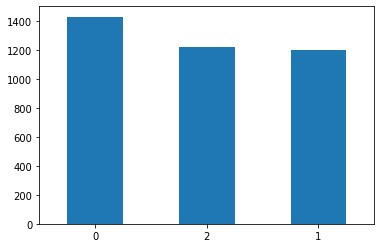

In [10]:
train_df['category'].value_counts().plot.bar(x='category', rot=0)

В целом у нас тут почти идельное распределение по типам чатов поэтому в будущем не придётся применять различные модели для балансировки.

# Text Pre-Processing

In [11]:
import text_hammer as th

Воспользуемся готовой библиотекой для чистки сообщений

In [12]:
def text_preprocessing(df, column):
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_stopwords(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.make_base(x))
    
    return df

In [13]:
if flag:
    clean_train_df = text_preprocessing(train_df, "message")

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

  0%|          | 0/3844 [00:00<?, ?it/s]

In [14]:
clean_train_df.to_csv('clean_train_df') # нужно чтобы каждый раз не проделывать одну и туже процедуру
clean_train_df

,id,message,category,amount_sym,amount_words,amount_numbers
0,271828,616 million bitcoin electrocate september wrap...,1,1454,242,28
1,271829,quiz thursday friday,0,25,4,0
2,271830,australian revenue authority start collect tax...,1,1080,169,10
3,271831,let continue present new review,2,48,10,0
4,271832,come future palette,2,31,5,0
...,...,...,...,...,...,...
3839,275667,air shooter kms man ask favourite subpoena pok...,2,1438,281,0
3840,275668,shit offthebook,0,31,4,0
3841,275669,time sky tabor,2,29,7,0
3842,275670,uraaaaaaaa,0,10,1,0


# Train Test split 

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(clean_train_df.message, 
                                                  clean_train_df.category, 
                                                  test_size = 0.2, 
                                                  stratify = clean_train_df.category,
                                                  random_state = 10122022)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3075,) (769,) (3075,) (769,)


# Convert sentences to word vectors

In [17]:
from keras.preprocessing.text import Tokenizer

Для начала посмотрим сколько у нас существует уникальных слов в датасете

In [29]:
%%time
uniq_words = {}

for message in clean_train_df['message'].values:
    uniq_words.update(dict.fromkeys(set(message.split())))

print("Количество уникальных значений в сообщениях: ", len(uniq_words))

Количество уникальных значений в сообщениях:  14907
Wall time: 70.4 ms


В нашем случае вышло примерно 15000 слов(и цифр). В целом, то что тут также есть цифры не критично так как наша цель найти максимальное значение для того, что позже воспользоваться им при использование Tokenizer. И будет не критично если у нас будет больше значений так как все лишние буду занулены.
В целом конечно можно посмотреть как часто встречается каждое слово в частности, но в нашем случае это излишне так как никак не может повлиять на конечную точность модели с учётом всех вводных задания

In [31]:
%%time
num_words = len(uniq_words)
tokenizer = Tokenizer(num_words, lower=True)
df_total = pd.concat([X_train, X_test], axis = 0) # Надо объединить тренировачный и тестоввый датасет чтобы учесть все слова. 
tokenizer.fit_on_texts(df_total)
print(len(tokenizer.word_index))

14902
Wall time: 249 ms


# Make all sentences the same length

In [33]:
from keras_preprocessing.sequence import pad_sequences

In [41]:
max_message_lenght = clean_train_df.message.str.len().max()
print(max_message_lenght)

X_train_ = tokenizer.texts_to_sequences(X_train)
X_train_pad = pad_sequences(X_train_, maxlen = max_message_lenght, padding='post')
X_test_ = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_, maxlen = max_message_lenght, padding = 'post')
print(X_train_pad.shape, X_test_pad.shape)

1909
(3075, 1909) (769, 1909)


In [44]:
X_train_pad, X_test_pad

(array([[   16,  2204,  3244, ...,     0,     0,     0],
        [  370,   151,   536, ...,     0,     0,     0],
        [  102,   315,  1597, ...,     0,     0,     0],
        ...,
        [   33,  1341, 13368, ...,     0,     0,     0],
        [   93,   127,  4827, ...,     0,     0,     0],
        [   83,     4,   136, ...,     0,     0,     0]]),
 array([[   35,  3284,   522, ...,     0,     0,     0],
        [ 4045,   368,  3412, ...,     0,     0,     0],
        [  901, 13371,  2633, ...,     0,     0,     0],
        ...,
        [  848,   519,   758, ...,     0,     0,     0],
        [  265,   380,     0, ...,     0,     0,     0],
        [ 3626,   125,    46, ...,     0,     0,     0]]))

# Model

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import xgboost as xgb

##  LogisticRegression

In [81]:
def logreg(X_train_pad, y_train, y_test):
    model_logreg = LogisticRegression()
    model_logreg.fit(X_train_pad, y_train)
    y_pred_logreg = model_logreg.predict(X_test_pad)
    acc = np.round(accuracy_score(y_pred_logreg, y_test), 4)
    print('accuracy %s' % acc)
    print(classification_report(y_test, y_pred_logreg))
    
    return y_pred_logreg, acc

In [82]:
%%time
y_pred, acc = logreg(X_train_pad, y_train, y_test)

accuracy 0.5735
              precision    recall  f1-score   support

           0       0.63      0.85      0.72       286
           1       0.62      0.50      0.55       240
           2       0.41      0.33      0.36       243

    accuracy                           0.57       769
   macro avg       0.55      0.56      0.55       769
weighted avg       0.56      0.57      0.56       769

Wall time: 1.73 s


c:\users\egorm\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## XGBOOST 

In [75]:
%%time
model_xgb = xgb.XGBClassifier(objective='multi:softmax', 
                          num_class=3,
                          max_depth=4, 
                          learning_rate=0.1, 
                          n_estimators=100, 
                          subsample=0.8)

model_xgb.fit(X_train_pad, y_train)

Wall time: 14.9 s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_class=3, num_parallel_tree=1, objective='multi:softmax', ...)

In [76]:
y_pred_xgb = model_xgb.predict(X_test_pad)
print ('accuracy %s' % np.round(accuracy_score(y_test, y_pred_xgb), 4))
print(classification_report(y_test, y_pred_xgb))

accuracy 0.6814
              precision    recall  f1-score   support

           0       0.68      0.82      0.74       286
           1       0.74      0.80      0.77       240
           2       0.59      0.40      0.48       243

    accuracy                           0.68       769
   macro avg       0.67      0.67      0.66       769
weighted avg       0.67      0.68      0.67       769



In [77]:
y_test

161     0
1720    0
2066    0
3706    0
2990    2
       ..
1104    0
1684    1
1542    1
523     0
935     2
Name: category, Length: 769, dtype: int64